In [16]:
import sys
import random
from collections import Counter
sys.path.append('../ml/Features.py')
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from scipy.spatial import distance
import Features as ft
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition # PCA
from sklearn.metrics import confusion_matrix

In [2]:
MAX_HEIGHT = 203
MAX_WIDTH = 142
SPEED = 3
SAMPLING_RATE = 8

In [3]:
def convert_file_to_data_frame(filename,id):
    my_file = open(filename,'r')
    lines = my_file.readlines()
    dict = {}
    data = []
    for line in lines:
        key = line.split('=')[0].rstrip()
        val = line.split('=')[1].rstrip()
        if dict.has_key(key):
            # we probably have all of them at this point
            height = MAX_HEIGHT - dict['UT']
            if height < 5:
                height = np.nan
            width = np.nan
            if dict.has_key('UL') and dict.has_key('UR'):
                if dict['UL'] > 140 or dict['UR'] > 140:
                    width = np.nan
                else:
                    width = MAX_WIDTH - dict['UL'] - dict['UR']
            data.append([height,width])
            dict = {}
        else:
            dict[key] = float(val)
    frame = DataFrame(data,columns=['height','width'])
    frame['id'] = id
    return frame
def get_frame(path):
    result = []
    for id in range(1, 21):
        filename = path + 'u%d.dat' % id
        frame = convert_file_to_data_frame(filename, id)
        result.append(frame)
    frame = pd.concat(result,ignore_index=True)
    return frame

In [4]:
frame = get_frame('../../data/')
frame['event'] = float(-1)

In [5]:
event_count = 1
max_id = frame['id'].max() + 1
for id in range(1,21):
    res = frame[(frame['height'] > 50) & (frame['id'] == id) & (frame['width'] > 10)]
    prev_index = 0
    for row in res.itertuples():
        if prev_index == 0 or row.Index - prev_index <= 3:
            frame.set_value(row.Index,'event',event_count)
        else:
            event_count +=1
            frame.set_value(row.Index,'event',event_count)
        prev_index = row.Index
    event_count +=1

In [6]:
first_event = int(frame[frame['event'] > -1]['event'].min())
last_event = int(frame[frame['event'] > -1]['event'].max())
columns = ['mean_height','min_height','max_height','mean_width','min_width','max_width','time','girth','id']
lines = []
index = []
for event_num in range(first_event,last_event + 1):
    data = frame[frame['event'] == event_num]
    line = []
    line.append(ft.extract_mean_height(data))
    line.extend(ft.extract_min_max_height(data))
    line.append(ft.extract_mean_width(data))
    line.extend(ft.extract_min_max_width(data))
    line.append(ft.extract_time(data,sampling_rate=SAMPLING_RATE))
    line.append(ft.extract_girth(data,SAMPLING_RATE,SPEED))
    line.append(data['id'].iloc[0])
    index.append(event_num)
    lines.append(line)
features = DataFrame(lines,index = index,columns=columns)

In [7]:
X = features[['mean_height','time','girth']]
labels_true = features['id']
X = StandardScaler().fit_transform(X)
# Compute DBSCAN
db = DBSCAN(eps=0.47, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [8]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 20
Homogeneity: 0.685
Completeness: 0.778
V-measure: 0.728
Adjusted Rand Index: 0.055
Adjusted Mutual Information: 0.090
Silhouette Coefficient: 0.492


/usr/local/lib/python2.7/site-packages/matplotlib/lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


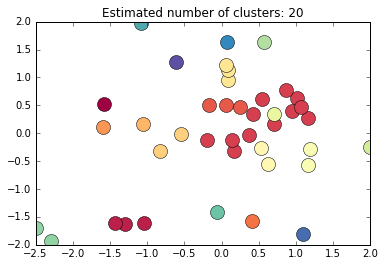

In [9]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [10]:
pca = decomposition.RandomizedPCA(n_components=20)
pca.fit(features)
pca.components_.shape

(9, 9)

In [11]:
labs = pd.read_csv('../../data/labs.csv')
label = Series(labs['label'])
label_true = Series(labs['label_true'])
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))

KeyError: 'label'

In [12]:
labels_true=np.array([ 0,  1,  1,  1,  3,  4,  2,  2,  2,  5,  6,  7,  7,  8,  3,  2,  2,9, 10, 11, 12,  2 ,  9 , 13, 14, 2, 10, 1, 2, 1, 15,  8,  2, 16,17, 14, 2, 2, 18, 19, 8])

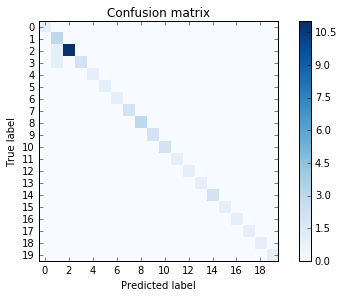

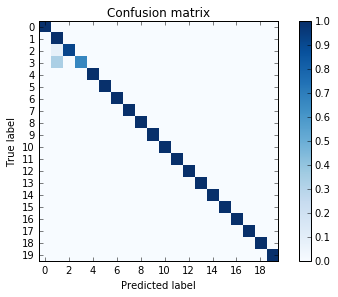

In [13]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(20)
    xtick_marks = np.arange(20,step=2)
    plt.xticks(xtick_marks, rotation=0)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion.png', dpi=1000, bbox_inches='tight')

cm = confusion_matrix(labels, labels_true)
np.set_printoptions(precision=2)
#print('Confusion matrix, without normalization')
#print(cm)
plt.figure()
plot_confusion_matrix(cm)
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#print('Normalized confusion matrix')
#print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized)
plt.show()

In [14]:
population = zip(labels, labels_true)
for _ in range(3):
    another = population[:]
    population.extend(another)
print len(population)
def getaccuracy(pop):
    count = 0.0
    for item in pop:
        if item[0] == item[1]:
            count +=1
    return count/len(pop)
print getaccuracy(population)

328
0.951219512195


In [24]:
sample = 0.7*len(population)
res = []
for _ in range(1000):
    random.shuffle(population)
    l = population[:int(sample)]
    accuracy = getaccuracy(l)
    accuracy = int(accuracy*1000)/10.0
    #print accuracy
    res.append(accuracy)
#plt.hist(l,10)
#plt.show()

In [25]:
cnt = Counter()
for ac in res:
    cnt[ac]+=1
print cnt

Counter({95.1: 203, 94.7: 187, 95.6: 179, 94.3: 148, 96.0: 112, 93.8: 70, 96.5: 57, 93.4: 19, 96.9: 12, 97.3: 8, 93.0: 4, 98.2: 1})


(array([   0.,    0.,    0.,    0.,    0.,    4.,    0.,   19.,    0.,
          70.,    0.,  148.,    0.,  187.,    0.,  203.,    0.,    0.,
         179.,    0.,  112.,    0.,   57.,    0.,   12.,    0.,    8.,
           0.,    0.]),
 array([ 92. ,  92.2,  92.4,  92.6,  92.8,  93. ,  93.2,  93.4,  93.6,
         93.8,  94. ,  94.2,  94.4,  94.6,  94.8,  95. ,  95.2,  95.4,
         95.6,  95.8,  96. ,  96.2,  96.4,  96.6,  96.8,  97. ,  97.2,
         97.4,  97.6,  97.8]),
 <a list of 29 Patch objects>)

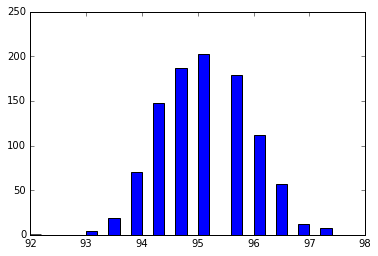

In [45]:
bins = [i/5.0 for i in range(460,490)]
plt.hist(cnt.keys(), weights=cnt.values(), bins=bins)

In [31]:
plt.show()